In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [2]:
import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    TrainingArguments, Trainer, pipeline, 
    EarlyStoppingCallback        
)
from ray import tune
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

2025-09-24 10:19:39.109533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758709179.444096      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758709179.552106      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Data & Model
model_id = "HuggingFaceTB/SmolLM2-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

raw_datasets = load_dataset("ag_news")
train_dataset = raw_datasets["train"]
eval_dataset  = raw_datasets["test"]

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval  = eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [4]:
# draw loss curve
def plot_loss(trainer, title):
    logs = trainer.state.log_history
    df = pd.DataFrame(logs)
    train_loss = df.dropna(subset=["loss"])
    eval_loss = df.dropna(subset=["eval_loss"])
    plt.figure(figsize=(7,5))
    plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
    plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [5]:
# text generation function
def show_output(trainer, title):
    gen_pipe = pipeline("text-generation", model=trainer.model, tokenizer=tokenizer,
                        device=0 if device=="cuda" else -1)
    prompt = "Wall"
    print(f"\n=== {title} ===")
    print(gen_pipe(prompt, max_new_tokens=30)[0]["generated_text"])

In [6]:
# text generation function
def show_output2(trainer, title, prompts, max_new_tokens=40):
    gen_pipe = pipeline(
        "text-generation",
        model=trainer.model,
        tokenizer=tokenizer,
        device=0 if device=="cuda" else -1
    )
    print(f"\n=== {title} ===")
    for prompt in prompts:
        generated = gen_pipe(prompt, max_new_tokens=max_new_tokens)[0]["generated_text"]
        print(f"Prompt: {prompt}\nGenerated: {generated}\n{'-'*40}")

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Step,Training Loss,Validation Loss
1000,1.603200,3.198907
2000,1.542200,3.094704
3000,1.486400,3.009346
4000,1.448400,2.945267
5000,1.408800,2.885685
6000,1.385300,2.827474
7000,1.368300,2.779433
8000,1.266600,2.747848
9000,1.182000,2.709960
10000,1.186100,2.679371


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

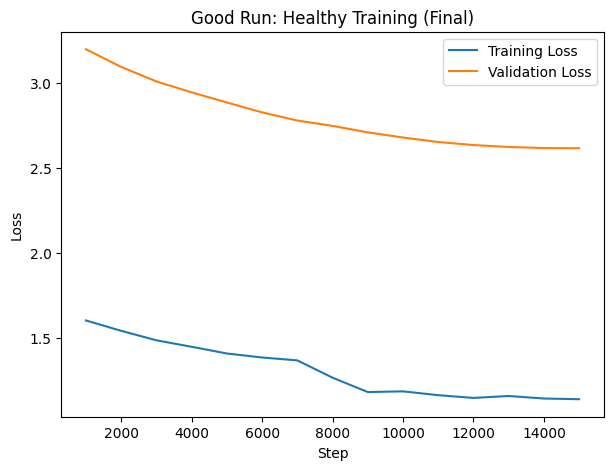

Device set to use cuda:0



=== Good Run Output (Final) ===
Wall Street down on rising oil prices, weak earnings Wall Street lost ground Wednesday, led by oil prices, as investors took profits to avoid the possibility of higher


In [7]:

# 使用最优超参数在全量数据训练最终 Good Run，并加早停
final_args = TrainingArguments(
    output_dir="good-run-final",
    per_device_train_batch_size=8,
    learning_rate= 2e-4,
    num_train_epochs= 2,
    weight_decay= 0.01,
    lr_scheduler_type="cosine",
    
    eval_strategy="steps",     # 每轮评估一次
    eval_steps=1000,
    save_strategy="steps",           # 每轮保存 checkpoint
    save_steps=1000,
    load_best_model_at_end=True,     # 训练结束加载验证集最优模型
    metric_for_best_model="eval_loss",  # 指标：最小化 eval_loss
    
    logging_steps=1000,
    save_total_limit=2,              # 最多保留 2 个 checkpoint，节省空间
    report_to="none"
)

early_stop_callback = EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=0.0
)

final_good_trainer = Trainer(
    model=AutoModelForCausalLM.from_pretrained(model_id).to(device),
    args=final_args,
    train_dataset=tokenized_train,       # 全量训练
    eval_dataset=tokenized_eval,
    processing_class=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stop_callback]
)

final_good_trainer.train()
plot_loss(final_good_trainer, "Good Run: Healthy Training (Final)")
show_output(final_good_trainer, "Good Run Output (Final)")

In [8]:
prompts = [
    "Q1",
    "Wall", 
    "Google"
]

show_output2(final_good_trainer, "Text Generation Examples", prompts)

Device set to use cuda:0



=== Text Generation Examples ===
Prompt: Q1
Generated: Q14.7 million people without Internet connection in Zimbabwe, says UN Security Council (AFP) AFP - More than 14 million people in Zimbabwe are without Internet access, the UN Security Council reported
----------------------------------------
Prompt: Wall
Generated: Wall Street #39;s dollar tumbles on US jobs report NEW YORK (CBS.MW) -- US economic growth is slowing, but the US dollar has seen gains in recent trading.
----------------------------------------
Prompt: Google
Generated: Google, Google Search Together to Sell 74 Million Songs Google Inc. and Apple Computer Inc. have announced that they will jointly sell 74 million songs over the next 18 months,
----------------------------------------


In [ ]:
# Bad Run: Oscillation
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
bad_args = TrainingArguments(
    output_dir="bad-run",
    per_device_train_batch_size=8,
    learning_rate=4e-3,       # 学习率大 → 震荡
    num_train_epochs=4,        # 多轮训练 → 过拟合
    weight_decay=0.0,          # 无正则化 → 过拟合
    lr_scheduler_type="constant",
    eval_strategy="steps",
    eval_steps=1000,
    logging_steps=1000,
    save_strategy="no",
    report_to="none"
)
bad_trainer = Trainer(
    model=model,
    args=bad_args,
    data_collator=data_collator,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval
)
bad_trainer.train()
plot_loss(bad_trainer, "Bad Run: Oscillation")
show_output(bad_trainer, "Bad Run Output")

In [ ]:
show_output2(bad_trainer, "Text Generation Examples", prompts)